In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import(
     StandardScaler,
     MinMaxScaler,
     OneHotEncoder,
     PolynomialFeatures
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score
)

from sklearn.feature_selection import SelectKBest

sns.set(style="darkgrid", font_scale=1.4)

# Загрузка данных

In [3]:
data = pd.read_csv("heart_train.csv")

In [4]:
data.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   
3           3  0.730337     0.007143    0.053162       0.0             0.0   
4           4  0.775281     0.757143    0.021998       0.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   
3      1.0      0.0                  1.0                 0.697023  ...   
4      1.0      0.0                  1.0                 0.412878  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047  

[5 rows x 28 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [6]:
data.isna().sum()

Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure  

# Предобработка данных 

* Проверим на дубликаты

In [7]:
data.duplicated().sum()

np.int64(0)

* Обычных дубликатов нет, проверим на наличие неявных дубликатов

In [8]:
def implicit_duplicates(data):
    for column in data.columns:
        if data[column].dtype == "object":
            print(data[column].unique())


In [9]:
implicit_duplicates(data)

['Male' 'Female' '1.0' '0.0']


* У нас многие переменные имеют не тот тип, поэтому у некоторых переменных поменяем тип

In [10]:
(data.nunique() < 5).sum()

np.int64(10)

* Заполнение пропусков в датасете будет выполнено нулевыми значениями, потому что в бинарных переменных пропуски логически соответствуют отсутствию признака (0), а в остальных числовых столбцах пропуски с высокой вероятностью означают нулевое значение показателя.

In [11]:
data = data.fillna(0)

In [12]:
data.nunique()

Unnamed: 0                         8685
Age                                  77
Cholesterol                         282
Heart rate                           87
Diabetes                              2
Family History                        2
Smoking                               2
Obesity                               2
Alcohol Consumption                   2
Exercise Hours Per Week            7933
Diet                                  4
Previous Heart Problems               2
Medication Use                        2
Stress Level                         11
Sedentary Hours Per Day            7933
Income                             7808
BMI                                7933
Triglycerides                       772
Physical Activity Days Per Week       8
Sleep Hours Per Day                   8
Heart Attack Risk (Binary)            2
Blood sugar                         239
CK-MB                               679
Troponin                            340
Gender                                4


In [13]:
data["Gender"].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

* В столбце Gender встречаются четыре типа значений: Male, Female, 1.0 и 0.0. Поскольку числовые значения 1.0 и 0.0 не имеют однозначной интерпретации (неизвестно, какому полу они соответствуют), их следует удалить из данных, чтобы сохранить только корректные категории — Male и Female.

In [14]:
data = data.query('Gender != "1.0" and Gender != "0.0"')

* Можно отметить, что признаки Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems и Medication Use являются номинальными переменными, так как принимают категориальные значения (да/нет).
Однако они уже представлены в виде числового кода (1 и 0) и имеют тип float, поэтому преобразовывать их обратно в тип object не требуется.

In [15]:
data["Diet"].unique()

array([1, 2, 0])

* Но в датасете есть столбец Diet (значения в нем 0, 1, 2), который тоже является номинальным. Его стоит обратно перевести в тип object

In [16]:
data["Diet"] = data["Diet"].astype("object")

* Возможно потребуется Stress Level, Physical Activity Days Per Week, Sleep Hours Per Day перевести тоже в тип object

### Краткий вывод по предобработке данных:

* Мы изучили дынные
* Проверили на явные и неявные дубликаты
* Обработали пропуски
* Преобразовали некоторые столбцы к нужному типу

# EDA

In [ ]:
def plot_histogram(data, name_columns, n_cols=2, bins=30):
    n_rows = (len(name_columns) + n_cols - 1) // n_cols  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for ax, col in zip(axes, name_columns):
        sns.histplot(data=data, x=col, bins=bins, kde=True, ax=ax)
        ax.axvline(data[col].median(), ls="--",color="red",label=f"Медиана = {round(data[col].median(),2)}")
        ax.legend()
        ax.set_title(col)

    for ax in axes[len(name_columns):]:
        fig.delaxes(ax)
    

    plt.tight_layout()
    plt.show()


def plot_bars(data, name_columns, n_cols=2, edgecolor='black', linewidth=1.0):

    n_rows = (len(name_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    for ax, col in zip(axes, name_columns):
        data[col].value_counts(ascending=False).plot(kind='bar', ax=ax, edgecolor=edgecolor, linewidth=linewidth)
        ax.set_title(f"Распределение: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Количество")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=360, ha='right')
    
      
    for ax in axes[len(name_columns):]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
    


### Построим гистограммы для количественных переменных

### 

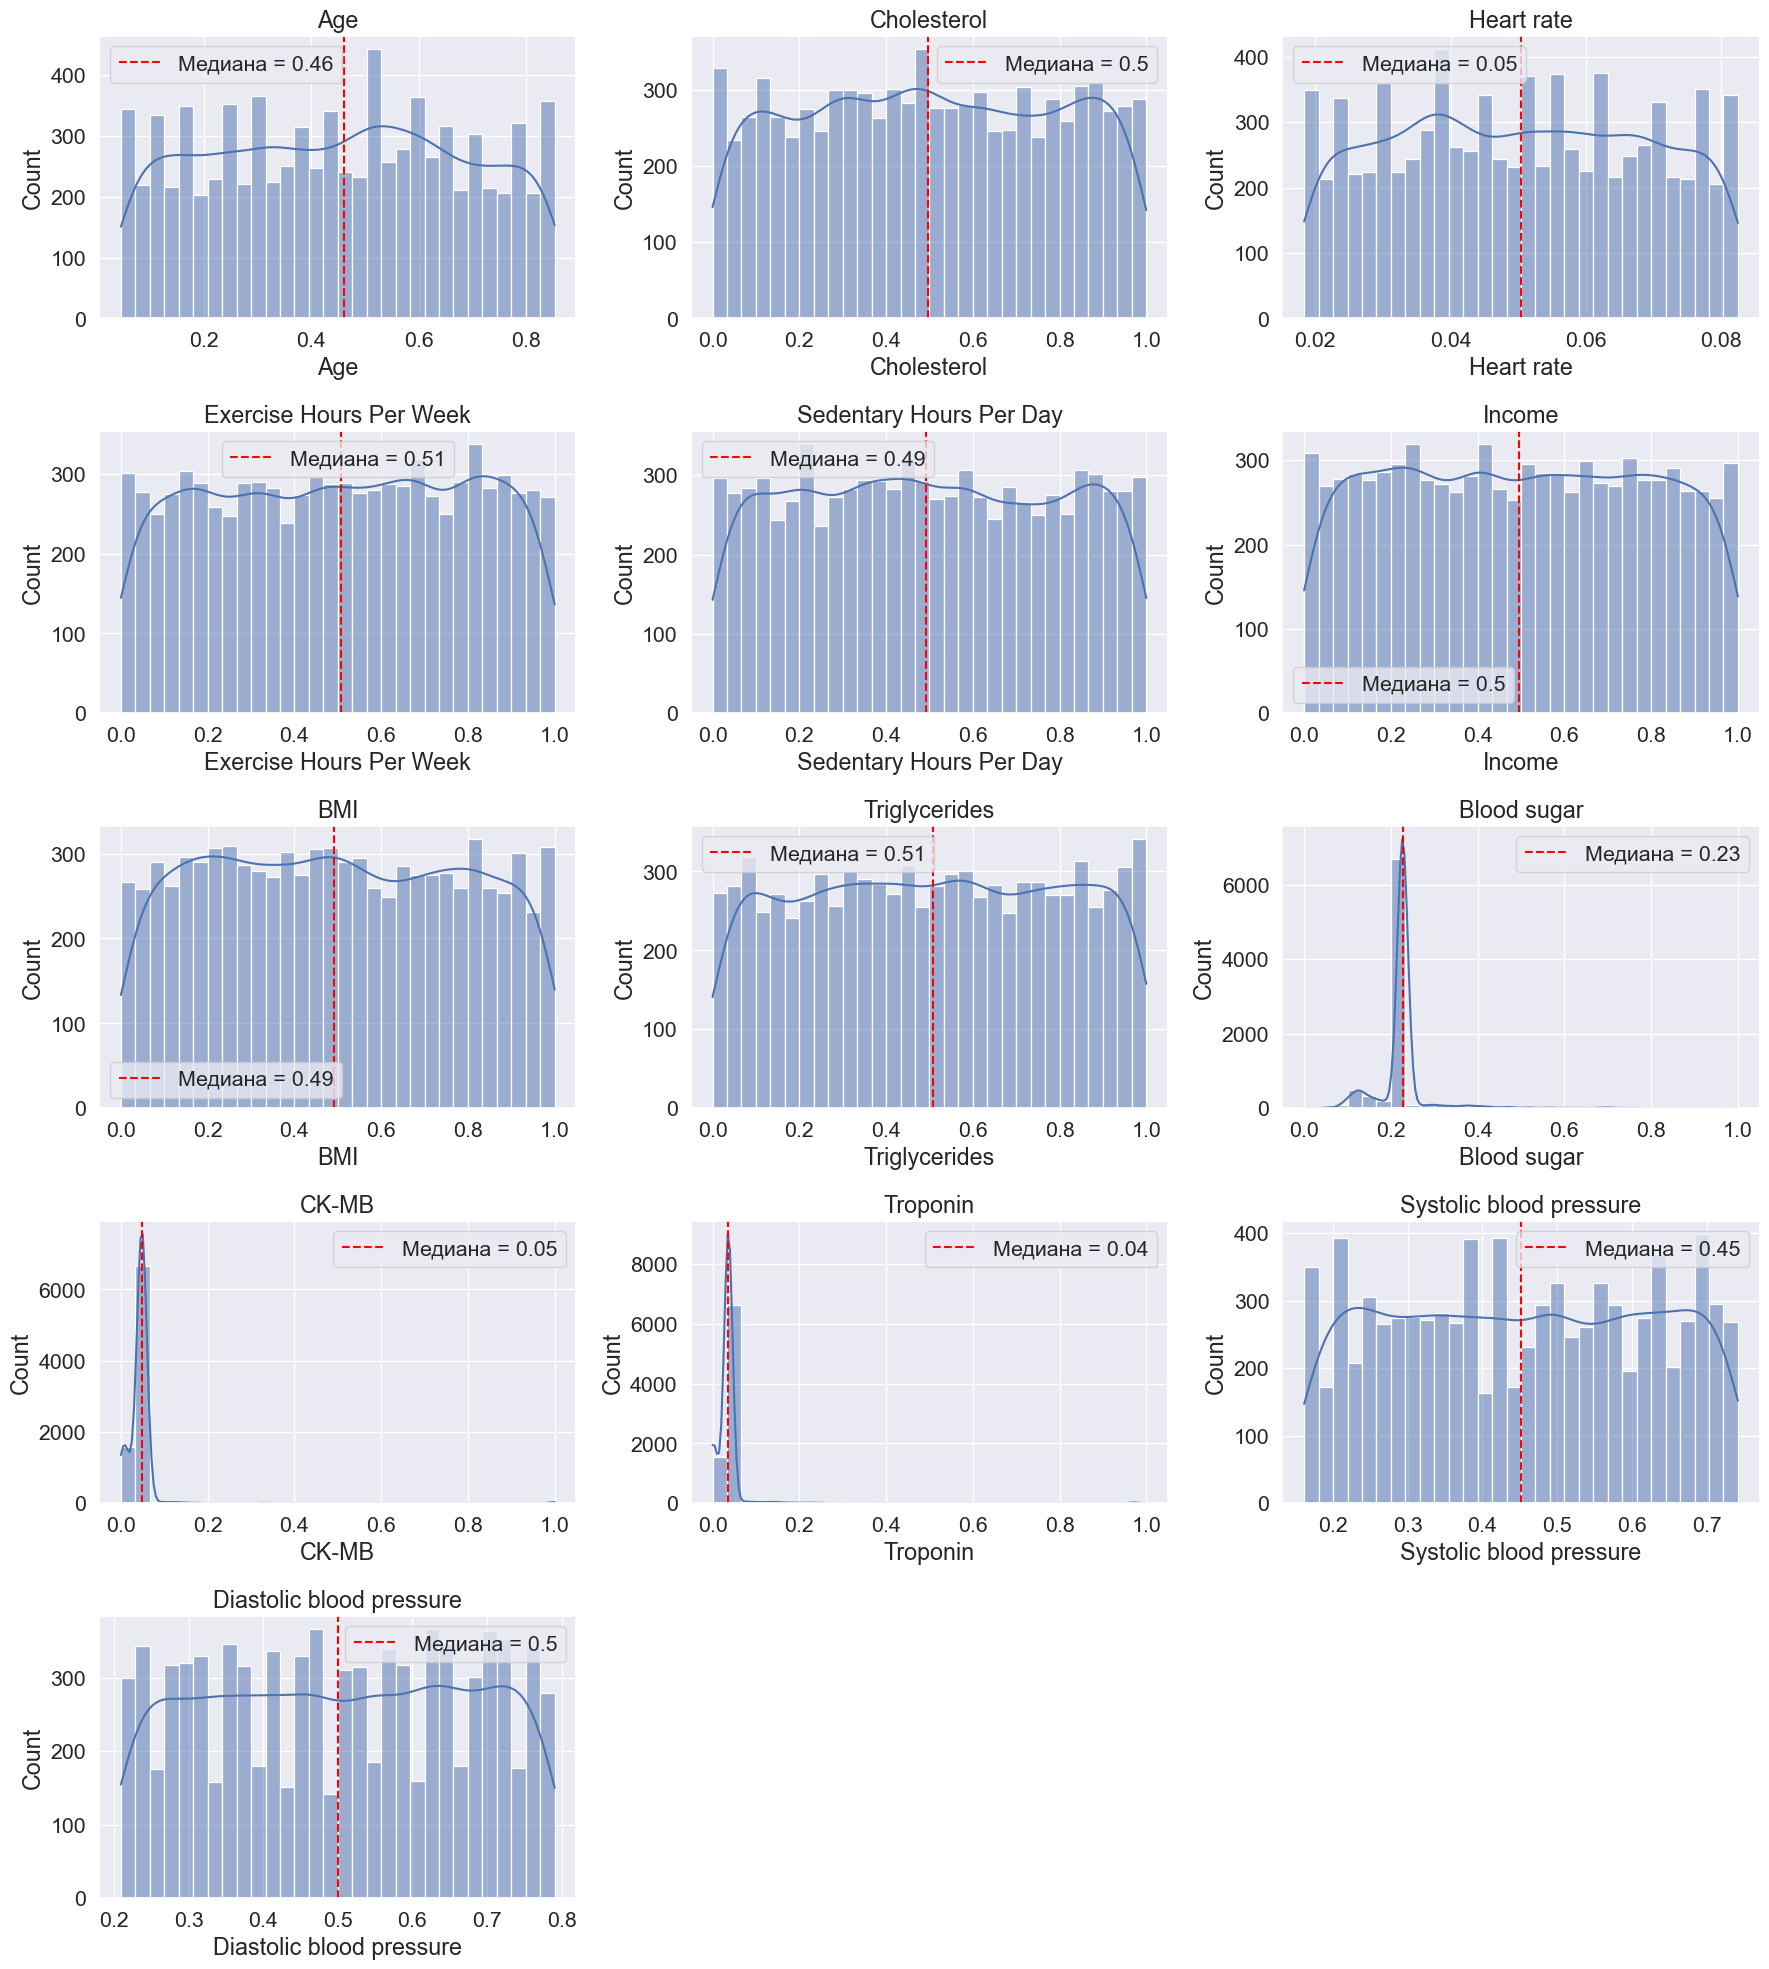

In [83]:
name_columns = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
    ]


plot_histogram(data, name_columns, n_cols = 3)





* Большинство признаков в датасете, кроме Blood sugar, CK-MB и Troponin, не содержат существенной интересной информации. Исследования показывают, что повышение уровня тропонина и/или повышение уровня CK-MB (выход за нормальные значения) однозначно связано с повреждением сердечной мышцы и может свидетельствовать о наличии инфаркта. Поскольку эти признаки напрямую отражают проявление целевого события — риска инфаркта — включение их в модель может привести к утечке целевого признака. Поэтому целесообразно удалить их из набора данных перед построением модели.

* Также стоит отметить, что повышение уровня глюкозы в крови связано с увеличением риска сердечно-сосудистых заболеваний. Поэтому признак “Blood sugar” может давать модели информацию, близкую к целевому событию, и его целесообразно исключить из набора данных.

In [84]:
data = data.drop(columns=["Blood sugar","CK-MB","Troponin"])

### Построим bar_plots для качественных переменных

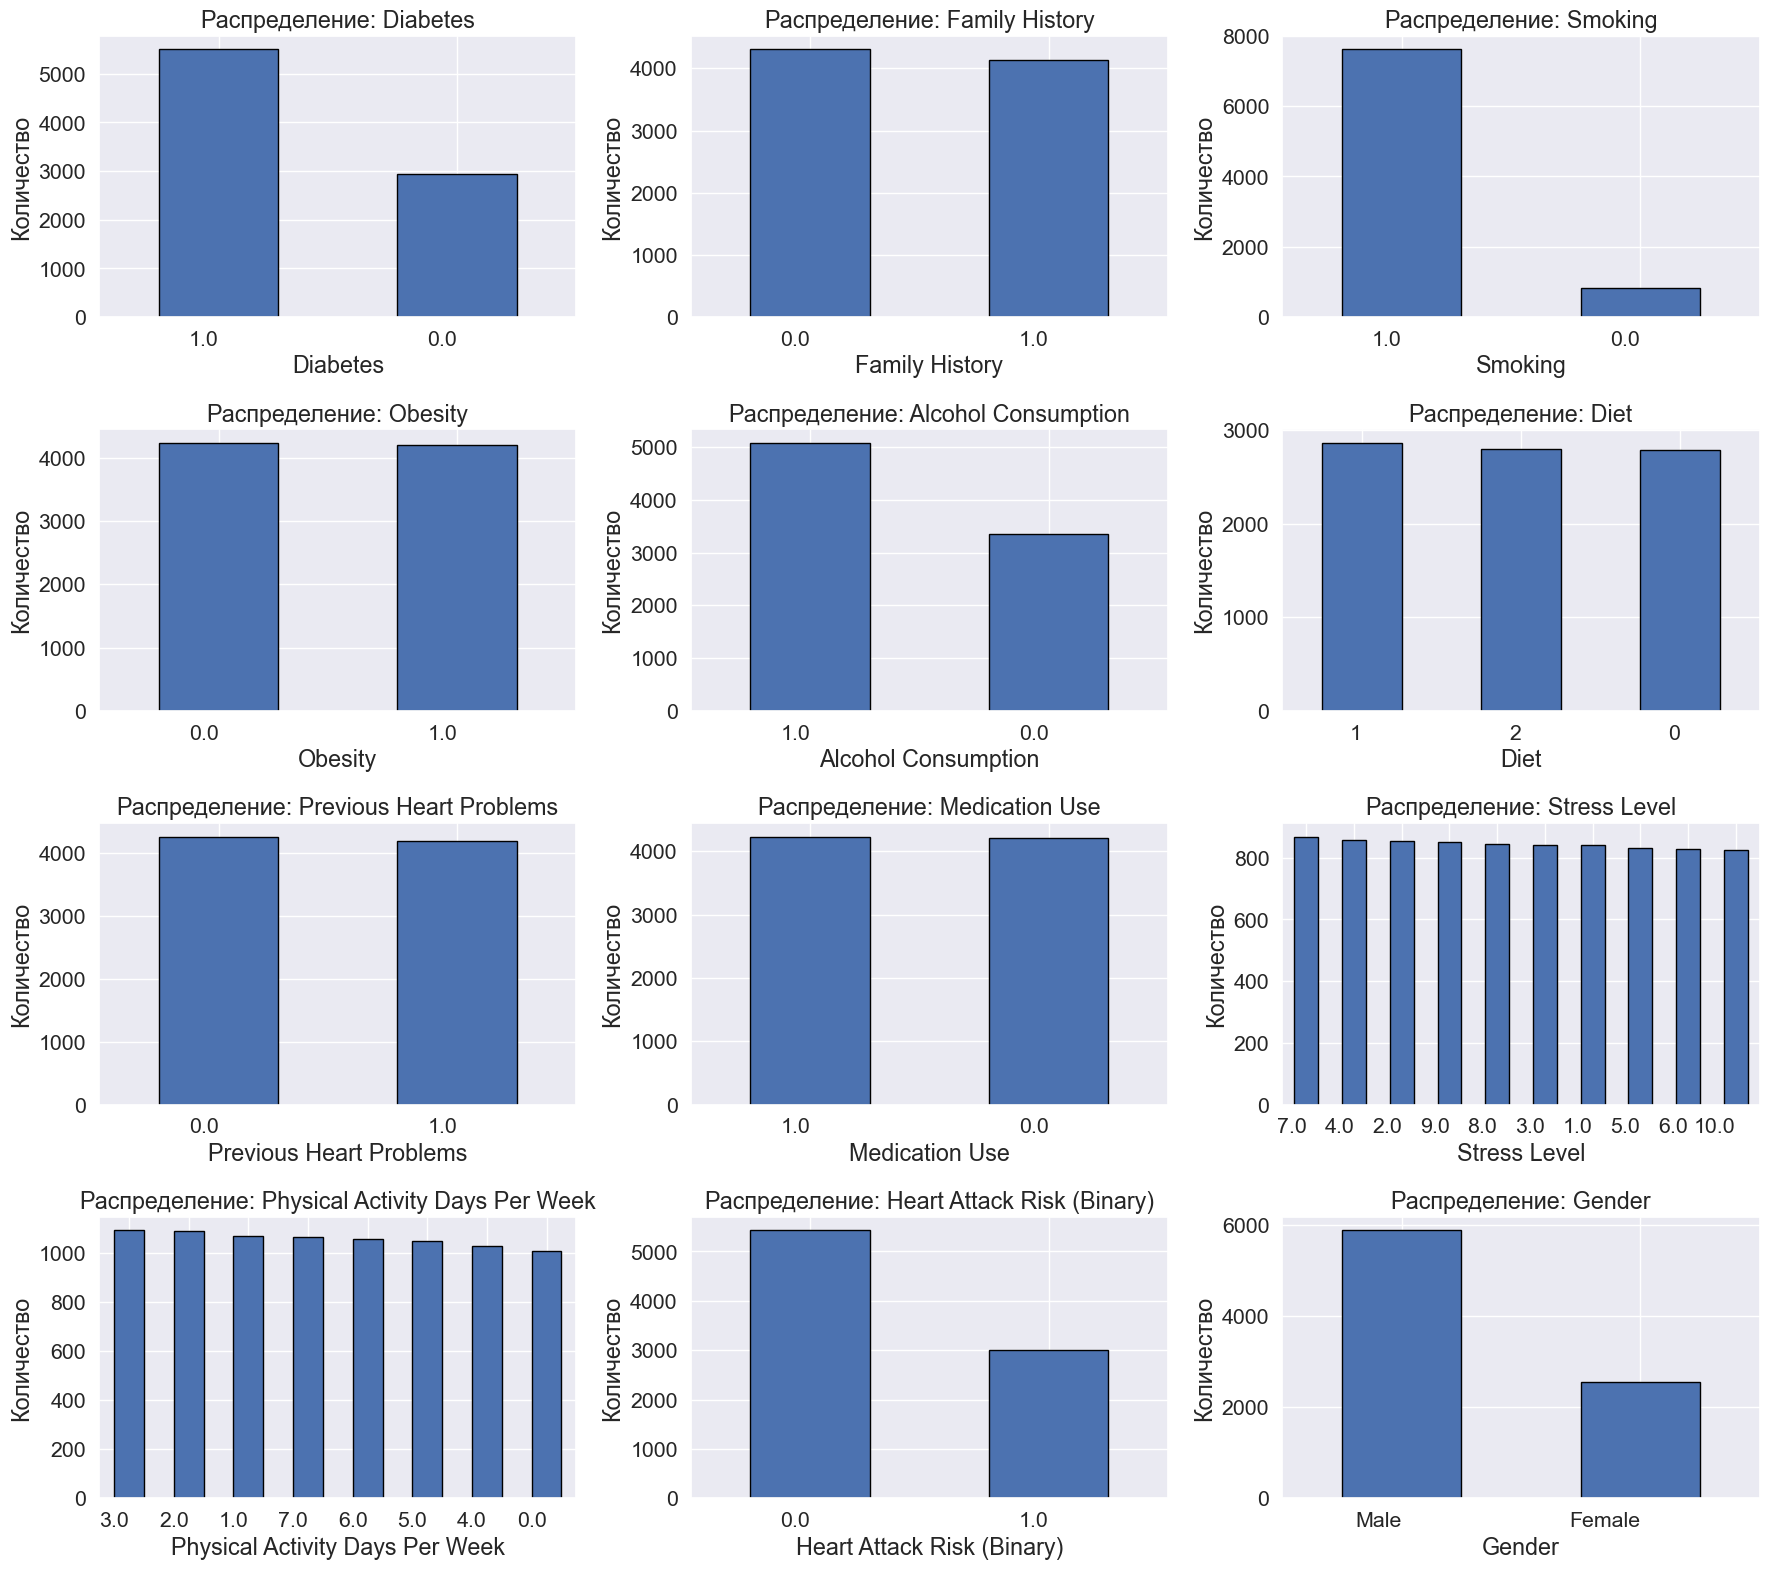

In [85]:
cat_columns = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Stress Level',
    'Physical Activity Days Per Week',
    'Heart Attack Risk (Binary)',
    'Gender'

]

plot_bars(data, cat_columns, n_cols=3)

В рассматриваемом наборе данных можно отметить следующие ключевые моменты:

* Присутствует значительная доля людей с диагнозом диабета (Diabetes).

* Приблизительно половина участников имеют наследственную предрасположенность (Family History) к сердечным заболеваниям, и половина — нет.

* Практически все участники являются курящими (Smoking).

* Количество людей с ожирением (Obesity) примерно равно количеству людей без ожирения.

* Число людей, употребляющих алкоголь (Alcohol Consumption), превышает число тех, кто его не употребляет.

* В выборке больше мужчин, чем женщин (Gender).

* Целевая переменная (Heart Attack Risk (Binary)) имеет несбалансированные классы — это означает, что модель, вероятно, покажет лучшую метрику Precision.»



### Построим матрицу корреляции

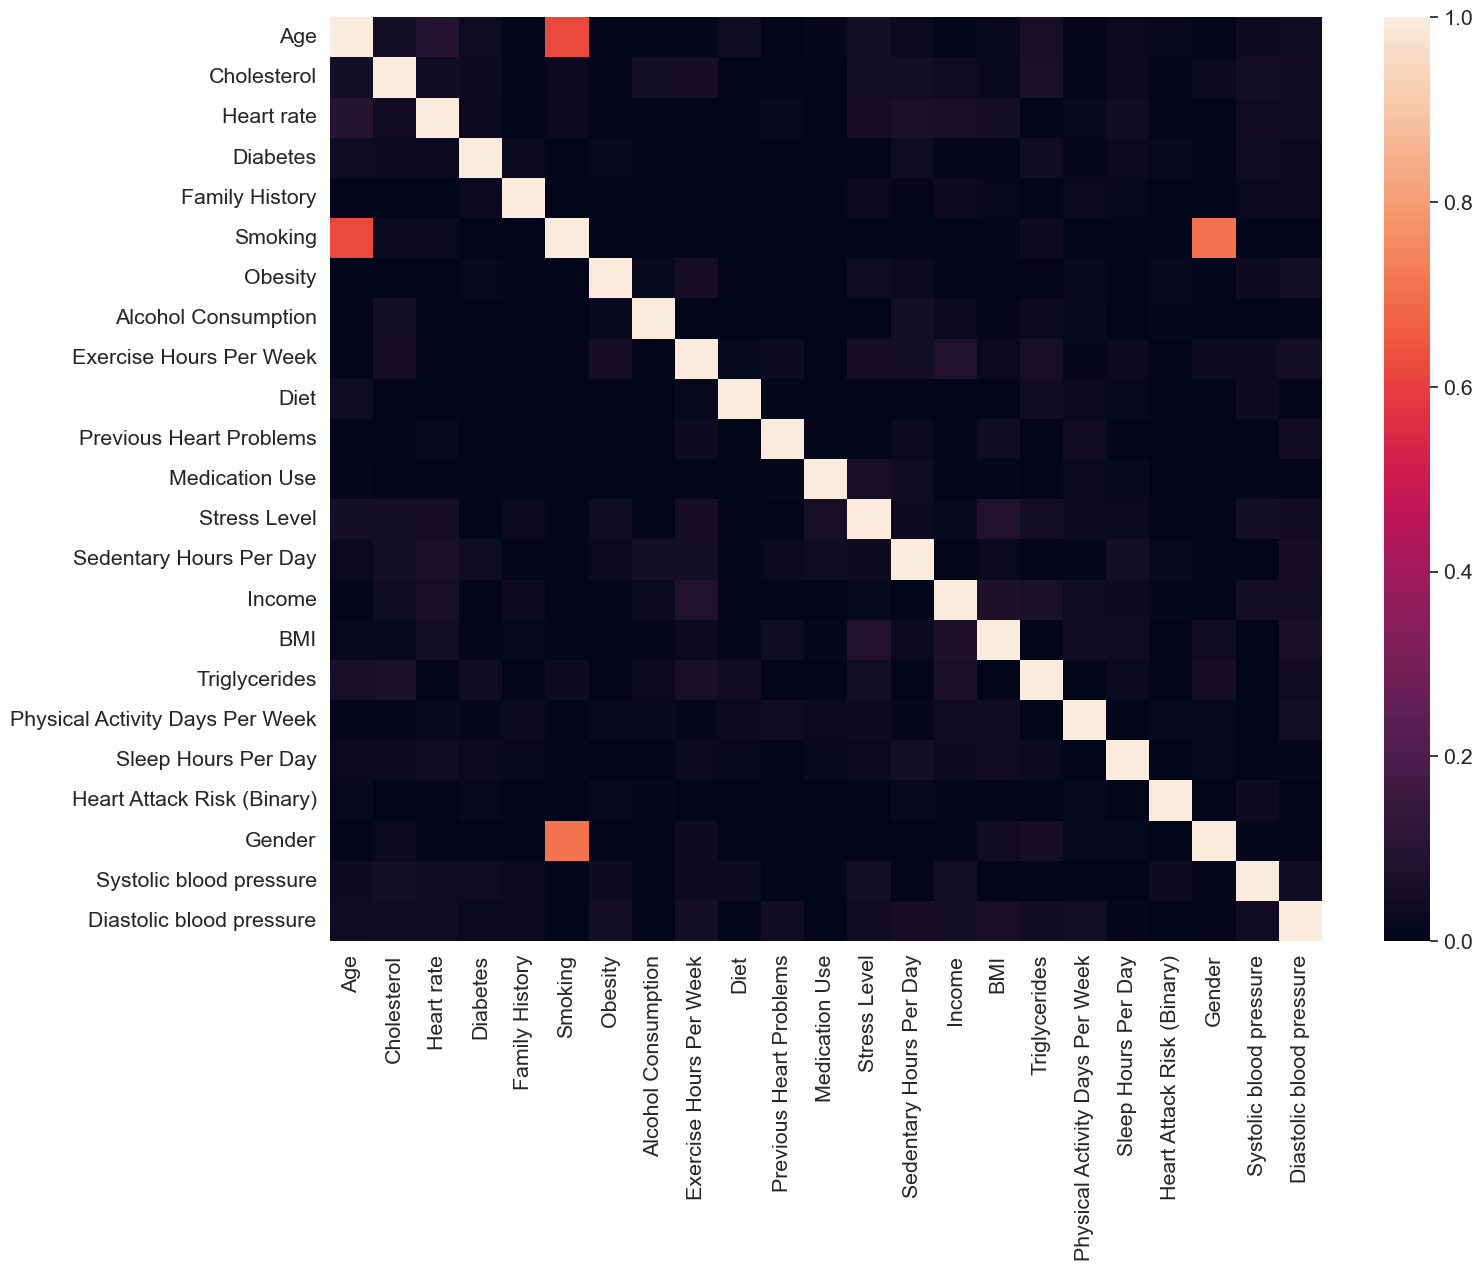

In [87]:
interval_cols = [
    "Age",
    "Cholesterol",
    "Heart rate",
    "Exercise Hours Per Week",
    "Sedentary Hours Per Day",
    "Income",
    "BMI",
    "Triglycerides",
    "Systolic blood pressure",
    "Diastolic blood pressure"
    ]

plt.figure(figsize=(16,12))
cm = phik.phik_matrix(data.drop(columns=["Unnamed: 0","id"]), interval_cols=interval_cols)
sns.heatmap(cm)
plt.show()

* Тепловая карта корреляций показывает, что между большинством признаков практически отсутствуют сильные линейные связи. Поэтому применение простых линейных моделей, предполагающих явные линейные зависимости между переменными, может оказаться неэффективным.

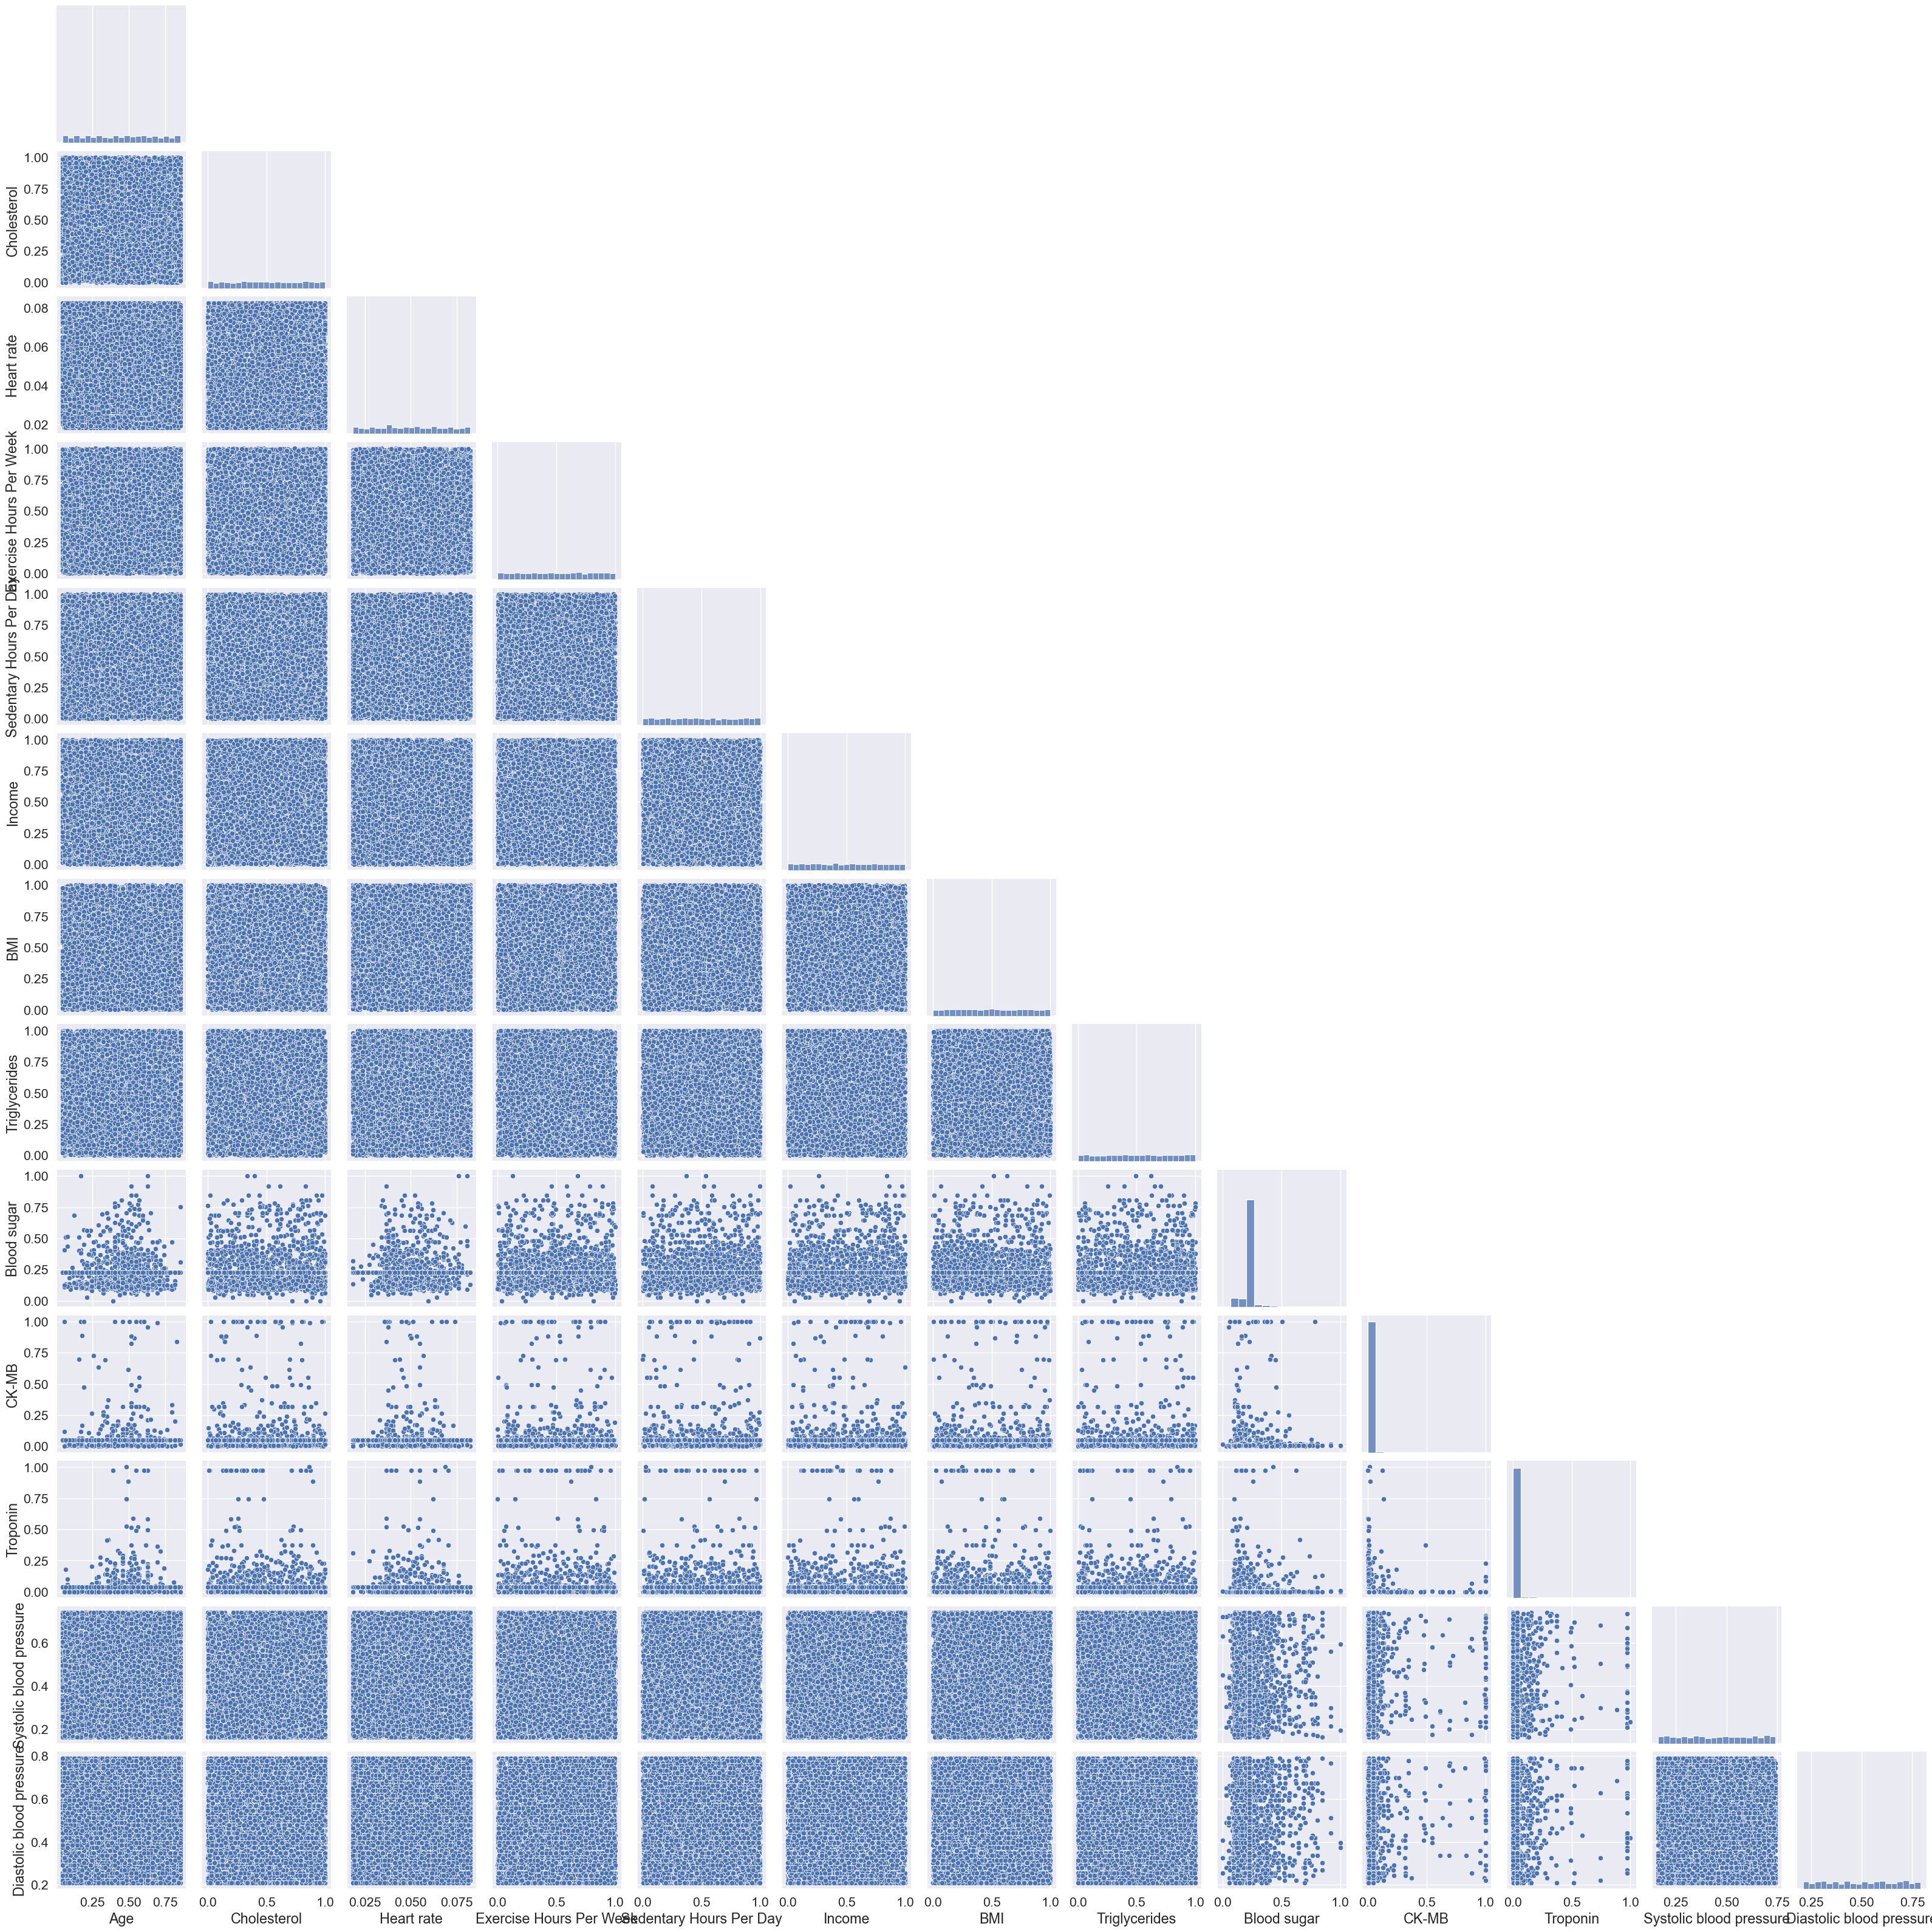

In [80]:
name_columns = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
    ]

sns.pairplot(data[name_columns], corner=True)
plt.show()

* Графики scatterplots поддтверждают, что между количественными переменными нету сильной корреляции

### Общий вывод:

После предварительного анализа набора данных можно сделать следующие ключевые выводы:

1) Признаки **CK-MB** и **Troponin** являются биомаркерами повреждения сердечной мышцы, они используются в клинической практике для диагностики Myocardial Infarction. Поскольку они напрямую отражают целевое событие (инфаркт), их включение в модель может привести к утечке целевого признака — поэтому их следует исключить из набора данных.

Также признак **Blood sugar** (уровень глюкозы в крови), хотя и является фактором риска сердечно-сосудистых заболеваний, может давать модели информацию, близкую к целевому событию, что повышает риск косвенной утечки. Поэтому его также разумно удалить.

2) Остальные переменные выборки имеют следующие особенности:

* Значительная доля участников имеют диагноз диабета (Diabetes).

* Примерно половина участников имеют семейную наследственность сердечных заболеваний (Family History), другая половина — нет.

* Практически все участники — курящие (Smoking).

* Приблизительно равное число участников с и без ожирения (Obesity).

* Людей, употребляющих алкоголь (Alcohol Consumption), больше, чем неупотребляющих.

* В выборке преобладают мужчины над женщинами (Gender).

* Целевая переменная (Heart Attack Risk (Binary)) представлена несбалансированно.

3) Анализ корреляций показывает, что между большинством признаков нет сильных линейных связей — тепловая карта, а также scatter-графики количественных переменных подтверждают слабую корреляцию между ними. Это означает, что применение простых линейных моделей, предполагающих сильную линейную зависимость между признаками, может быть неэффективным в данном случае.

# Составим модель машинного обучения